##  Apply spatial GP on slices of DEM datacube

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install git+https://github.com/friedrichknuth/gtsa.git 
%pip install gdown tools mamba

  Cloning https://github.com/friedrichknuth/gtsa.git to /tmp/pip-req-build-o5dfpdh2
  Running command git clone --filter=blob:none --quiet https://github.com/friedrichknuth/gtsa.git /tmp/pip-req-build-o5dfpdh2
  Resolved https://github.com/friedrichknuth/gtsa.git to commit d8ee444da75b072f50668d6639fe4c5d66c89f8a
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import xarray as xr
import numpy as np
import torch
import gpytorch
import gtsa
import pandas as pd

Read in a chunk of the data. All slices in time, but a subsection in space.

In [4]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'

baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', 
                           storage_options={"anon": True}, decode_times=False)

baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 12089, x: 11383)
Coordinates:
  * time         (time) int64 0 1084 8396 8416 9827 ... 26510 26580 26655 26753
  * x            (x) float64 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y            (y) float64 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 712, 670), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [95]:
small_baker_ds = gtsa.geospatial.extract_dataset_center_window(baker_ds, size = 100)

Dataset center: 586638.4387119232, 5403404.566348841
Test column size: 100.0 by 100.0 in spatial coordinate units.
No CRS defined.
Using xarray slicing to select data along spatial coordinate axes.


In [96]:
small_baker_ds = small_baker_ds.compute()

Define GP model class. Since we are predicting on a constant grid, we use the version specified in [this tutorial](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Grid_GP_Regression.html#GP-Regression-with-Grid-Structured-Training-Data). This vastly speeds up training as we demonstrate in the benchmarking notebook.

In [7]:
class GridGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(GridGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Let's walk through an example where we train a spatial GP on one slice.

In [8]:
slice = small_baker_ds.isel(time=0)

In [9]:
# Get coordinate grid, convert training data to tensors
grid = torch.from_numpy(np.stack([slice.x.values, slice.y.values], axis=-1)).float()
# N.b. the grid regression GP requires input tensors are doubles! (= np.float32)
xyz  = slice.band1.to_dataframe().dropna().reset_index().to_numpy().astype(np.float32)

xy   = torch.from_numpy(xyz[:, :2]) # exclude time
z    = torch.from_numpy(xyz[:, -1])

# Split into train/test
is_train = torch.rand(size=(xy.shape[0],)) < 0.8

xy_train = xy[is_train, :]
z_train  =  z[is_train]

xy_test  = xy[~is_train, :]
z_test   =  z[~is_train]

# Train the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridGPRegressionModel(grid, xy_train, z_train, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 10

for _ in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xy_train)
    # Calc loss and backprop gradients
    loss = -mll(output, z_train)
    loss.backward()
    optimizer.step()

    print(loss.item())

model.eval()
likelihood.eval()

1643267.0
1459250.375
1298826.375
1160523.25
1045020.0
942394.8125
849263.9375
767349.6875
698986.625
637993.5


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [10]:
# Get predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(xy_test))

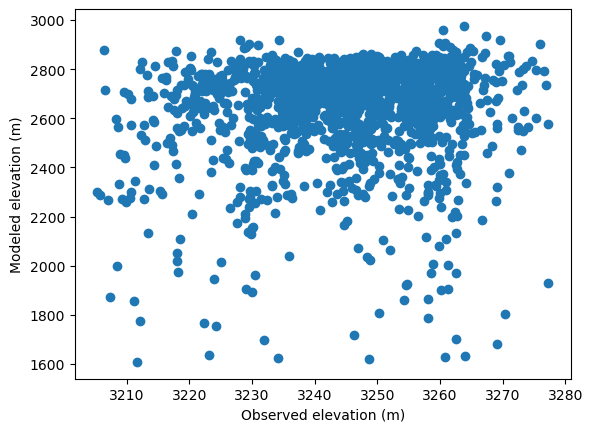

In [11]:
# Plot result
import matplotlib.pyplot as plt

plt.scatter(z_test.numpy(), observed_pred.mean.numpy())
plt.xlabel("Observed elevation (m)")
plt.ylabel("Modeled elevation (m)")
plt.show()

This is pretty bad, but at least we get *something*. Prior research indicates that X and Y coordinates do not covary well with elevation. This is why our other examples use time as the input dimension.

Now, we functionalize the above code so we can supply it to `xr.apply_ufunc`.

In [194]:
def gapfill_spatial_gp(data, y, x, train_iter=10):
    # print(data.shape, y.shape, x.shape)
    
    # If this slice has no nans, simply return the original data
    if np.all(~np.isnan(data)):
        return data
    
    xmesh, ymesh = np.meshgrid(y, x)

    grid = torch.from_numpy(np.stack([y, x], axis=-1).astype(np.float32))

    # Create input tensors
    mask = ~np.isnan(data.flatten())
    xy = torch.from_numpy(np.stack([ymesh.flatten(), xmesh.flatten()], axis=-1).astype(np.float32))
    z = torch.from_numpy(data.flatten().astype(np.float32))

    xy_subset = xy[mask, :]
    z_subset  = z[mask]

    # Create model and train
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GridGPRegressionModel(grid, xy_subset, z_subset, likelihood)
    
    model.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
    for _ in range(train_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xy_subset)
        # Calc loss and backprop gradients
        loss = -mll(output, z_subset)
        loss.backward()
        optimizer.step()
    
        # print(loss.item())

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        model.eval()
        likelihood.eval()
        pred = likelihood(model(xy))
    
    return pred.mean.numpy().reshape(data.shape)

Each time slice is independently fit, so we can parallelize the operation over dask.

In [195]:
from dask.distributed import Client
import logging
import warnings

warnings.simplefilter("ignore")
client = Client(silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/s-kganz/proxy/43371/status,
Dashboard: /user/s-kganz/proxy/43371/status,Workers: 4
Total threads: 4,Total memory: 15.33 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34935,Workers: 4
Dashboard: /user/s-kganz/proxy/43371/status,Total threads: 4
Started: Just now,Total memory: 15.33 GiB
Comm: tcp://127.0.0.1:37209,Total threads: 1
Dashboard: /user/s-kganz/proxy/33573/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:43113,


In [196]:
small_chunky = small_baker_ds.chunk({"time": 1})

xs = small_chunky.x.values
ys = small_chunky.y.values

small_chunky["gap_filled_band1"] = xr.apply_ufunc(
    lambda d: gapfill_spatial_gp(d, ys, xs),
    small_chunky.band1,
    input_core_dims = [["y", "x"]],
    output_core_dims = [["y", "x"]],
    output_dtypes=[np.float32],
    vectorize=True,
    dask="parallelized"
).compute()

In [199]:
small_chunky

<xarray.Dataset>
Dimensions:           (time: 55, y: 101, x: 101)
Coordinates:
  * time              (time) int64 0 1084 8396 8416 ... 26510 26580 26655 26753
  * x                 (x) float64 5.866e+05 5.866e+05 ... 5.867e+05 5.867e+05
  * y                 (y) float64 5.403e+06 5.403e+06 ... 5.403e+06 5.403e+06
Data variables:
    band1             (time, y, x) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    spatial_ref       int64 0
    plusone           (time, x, y) float32 dask.array<chunksize=(1, 101, 101), meta=np.ndarray>
    gap_filled_band1  (time, y, x) float32 2.229e+03 2.509e+03 ... 3.257e+03
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

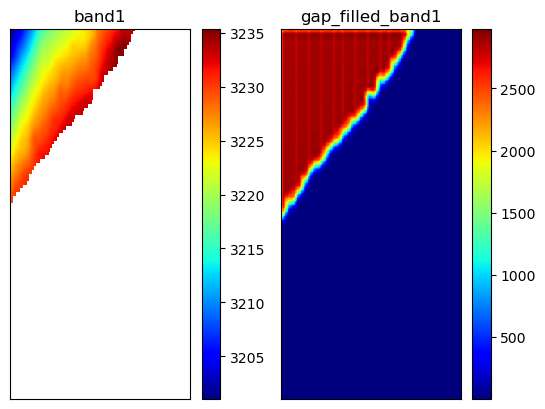

In [209]:
def compare_var_at_time_step(data, t, var1, var2):
    data_sel = data.sel(time=t)

    # Left plot
    plt.subplot(1, 2, 1)
    plt.title(var1)
    plt.imshow(data_sel[var1], cmap='jet', aspect='auto')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

    # Right plot
    plt.subplot(1, 2, 2)
    plt.title(var2)
    plt.imshow(data_sel[var2], cmap='jet', aspect='auto')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    

compare_var_at_time_step(small_chunky, 11710, "band1", "gap_filled_band1")